In [89]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import butter, lfilter

In [90]:
def generateChirp(start, end, sr, dur, samples = None):
    '''
    Generates a chirp signal

    Parameters:
    start (float): start frequency of the chirp
    end (float): end frequency of the chirp
    sr (num): sampling rate
    dur (num):  time duration of tone
    '''
    if samples is None:
        samples = int(sr * dur)
    time = np.linspace(0, dur, samples, False)

    linear_chirp = librosa.chirp(fmin=start, fmax=end, sr = sr, length = samples, duration=dur, linear=True)  
    
    return linear_chirp


In [91]:
def generateChirpWithStartDelay(start, end, sr, dur, start_delay, samples=None):
    '''
    Generates a chirp signal with a start delay

    Parameters:
    start (float): start frequency of the chirp
    end (float): end frequency of the chirp
    sr (num): sampling rate
    dur (num): time duration of tone
    start_delay (num): start delay duration in seconds
    '''
    total_duration = dur + start_delay  # Calculate the total duration of the output signal
    
    if samples is None:
        samples = int(sr * total_duration)  # Calculate total samples based on total duration
    
    time = np.linspace(0, total_duration, samples, False)

    linear_chirp = librosa.chirp(fmin=start, fmax=end, sr=sr, length=samples, duration=dur, linear=True)

    # Generate zeros for the start delay period
    start_delay_samples = int(sr * start_delay)
    start_delay_signal = np.zeros(start_delay_samples)

    # Combine the start delay and chirp signals
    chirp_with_start_delay = np.concatenate((start_delay_signal, linear_chirp))

    return chirp_with_start_delay


In [92]:
def signal_info(signal, sample_rate):
    '''
    Displays sampling rate, time duration and number of samples in the signal
    
    Parameters:
    signal (np.array): the signal
    sample_rate (num): sampling rate
    '''
    duration = len(signal)/ sample_rate
    n_samples = int(duration * sample_rate)
    #time = np.arange(0, n_samples) / sample_rate

    print("Sampling Rate:", sample_rate)
    print("Signal time duration: ", duration)
    print("Number of samples: ", n_samples)

In [93]:
def plot_spectogram(signal, sr, n_fft = 128, title = "Spectrogram", hop_length = None, win_length = None, ax = None):
    '''
    Displays a spectrogram (Frequency vs Time) for a signal

    Parameters:
    signal (np.array): the signal
    n_fft (num): length of the windowed signal. 
       Default is 128
    title (str): title of plot. Default is "Spectrogram".
    hop_length (int): number of audio samples between adjacent STFT columns. 
        If hop_length is not given then its value is taken as int(n_fft / 4)
    win_length (int <= n_fft): Each frame of audio is windowed by window of this length 
    ax(matplotlib.axes.Axes): The target axes instance for the plot.

    '''
    if hop_length is None:
        hop_length = int(n_fft / 4)
    
    stft = librosa.stft(y=signal, n_fft = n_fft, hop_length = hop_length, win_length = win_length)
    spectrogram = np.abs(stft)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    
    if hop_length is None:
        hop_length = int(n_fft / 4)  # You can adjust the hop length calculation as needed
    frame_times = librosa.frames_to_time(np.arange(spectrogram.shape[1]), sr=sr, hop_length=hop_length)

    #plt.figure(figsize=(10, 6))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='linear',x_coords=frame_times, ax=ax)
    #print(sr)
    #print(frame_times[len(frame_times)-1])
    
    #plt.ylim(17000,20000)
    
    #plt.colorbar(format='%+2.0f dB')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)

In [94]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

In [95]:
def butter_lowpass_filter(data, cutoff, fs, order=5):

    '''
    Applies a lowpass Butterworth filter to the input signal and returns the filtered signal.

    Parameters:
    data (np.array): The signal to be filtered
    cutoff (float): The cutoff frequency for the lowpass filter
    fs (float): The sampling rate of the signal
    order (int): The order of the Butterworth filter. Default is 5
    '''
    
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

\begin{gather*}
    \Delta\ t = \frac{2d}{v_{\text{sound}}} \\ \\
    \text{Beat frequency} = f_{\text{b}} = S \Delta t = \frac{f_{\text{0}} - f_{\text{1}}}{T_{\text{sweep}}} \cdot \Delta t \\
\end{gather*}

For a distance of 1m, substituting the values we get

\begin{align*} \\
    \Delta\ t = \frac{2 \cdot 1~m}{343~m/s} = 0.0058 s\\ \\
\end{align*} \\ 

The frequency of the corresponding IF signal is given by $ f_{\text{b}} $.

\begin{align*}\\
    f_{\text{b}} = \frac{(20000 - 18000)~Hz}{0.01075~s} \cdot(0.0058~s) = 1079.069~Hz\\
\end{align*}

Thus, considering the ideal case where the object is at a distance of 1 m from the smartphone, the reflected signal should return after a delay of 0.0058 s. After mixing and filtering, the resulting signal having a constant frequency equal to 1079.069 Hz.


In [96]:
# Generate chirp signals 
sampling_rate = 48000
duration = 10

d = 1
delay_duration = (2*d)/343
delay_duration = round(delay_duration, 4)

print("Distance:", d, "m", "\nTime Delay:", delay_duration, "s")
'''
chirp = generateChirp(18000,20000, sampling_rate, duration, samples=512)
delayed_chirp = generateChirpWithDelay(18000, 20000, sampling_rate, duration, delay_duration)

repeated_chirp = np.tile(chirp, 10)
sf.write('18-20kHz_chirp_rep_python.wav', repeated_chirp, sampling_rate)
sf.write('18-20kHz_chirp_delayed_python.wav', delayed_chirp, sampling_rate)
'''

Distance: 1 m 
Time Delay: 0.0058 s


"\nchirp = generateChirp(18000,20000, sampling_rate, duration, samples=512)\ndelayed_chirp = generateChirpWithDelay(18000, 20000, sampling_rate, duration, delay_duration)\n\nrepeated_chirp = np.tile(chirp, 10)\nsf.write('18-20kHz_chirp_rep_python.wav', repeated_chirp, sampling_rate)\nsf.write('18-20kHz_chirp_delayed_python.wav', delayed_chirp, sampling_rate)\n"

In [97]:
# Load the transmitted and received signals
#signal, sample_rate =librosa.load("/Users/Eshita/Desktop/Stuff/FMCW/FMCW Repo/Verification Experiment/FMCW /FMCW Data/18-20kHz_chirp_10.75ms_python.wav", sr = 48000)
#chirp_rec, sample_rate = librosa.load("/Users/Eshita/Desktop/Stuff/FMCW/FMCW Repo/Verification Experiment/FMCW /FMCW Data/18-20kHz_chirp_10.75ms_delayed.wav", sr = 48000)

signal, sample_rate =librosa.load("/Users/Eshita/Desktop/Stuff/FMCW/FMCW Repo/Verification Experiment/FMCW /FMCW Data/18-20kHz_chirp_rep_python.wav", sr = 48000)
chirp_rec, sample_rate = librosa.load("/Users/Eshita/Desktop/Stuff/FMCW/FMCW Repo/Verification Experiment/FMCW /FMCW Data/Ideal+delayed+periodic/18-20kHz_chirp_10.75ms_11.7Hz._delayed_rep.wav", sr = 48000)

# Display information about the signals
print("Transmitted signal:-")
signal_info(signal, sample_rate)
print("\nReceived signal:-")
signal_info(chirp_rec, sample_rate)

Transmitted signal:-
Sampling Rate: 48000
Signal time duration:  0.10666666666666667
Number of samples:  5120

Received signal:-
Sampling Rate: 48000
Signal time duration:  0.16458333333333333
Number of samples:  7900


Text(0, 0.5, 'Amplitude')

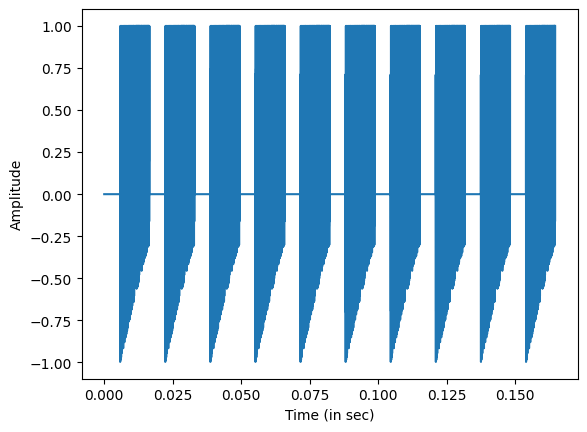

In [98]:
# Time vs Amplitude plot for the received signal
plt.plot([i/sample_rate for i in range(len(chirp_rec))], chirp_rec)
plt.xlabel("Time (in sec)")
plt.ylabel("Amplitude")
#plt.xlim(0,0.017)

In [99]:
# Compute FFT for transmitted and received signals
F_in,A_in = compute_fft(signal, sample_rate)
F_out,A_out = compute_fft(chirp_rec, sample_rate)

# Display the maximum frequencies 
print("Maximum frequency in input signal: ", F_in[np.argmax(A_in)])
print("Maximum frequency in output signal: ", F_out[np.argmax(A_out)])
print("Difference of frequency (beat freq): ", np.abs(F_in[np.argmax(A_in)] - F_out[np.argmax(A_out)]))



Maximum frequency in input signal:  18375.0
Maximum frequency in output signal:  0.0
Difference of frequency (beat freq):  18375.0


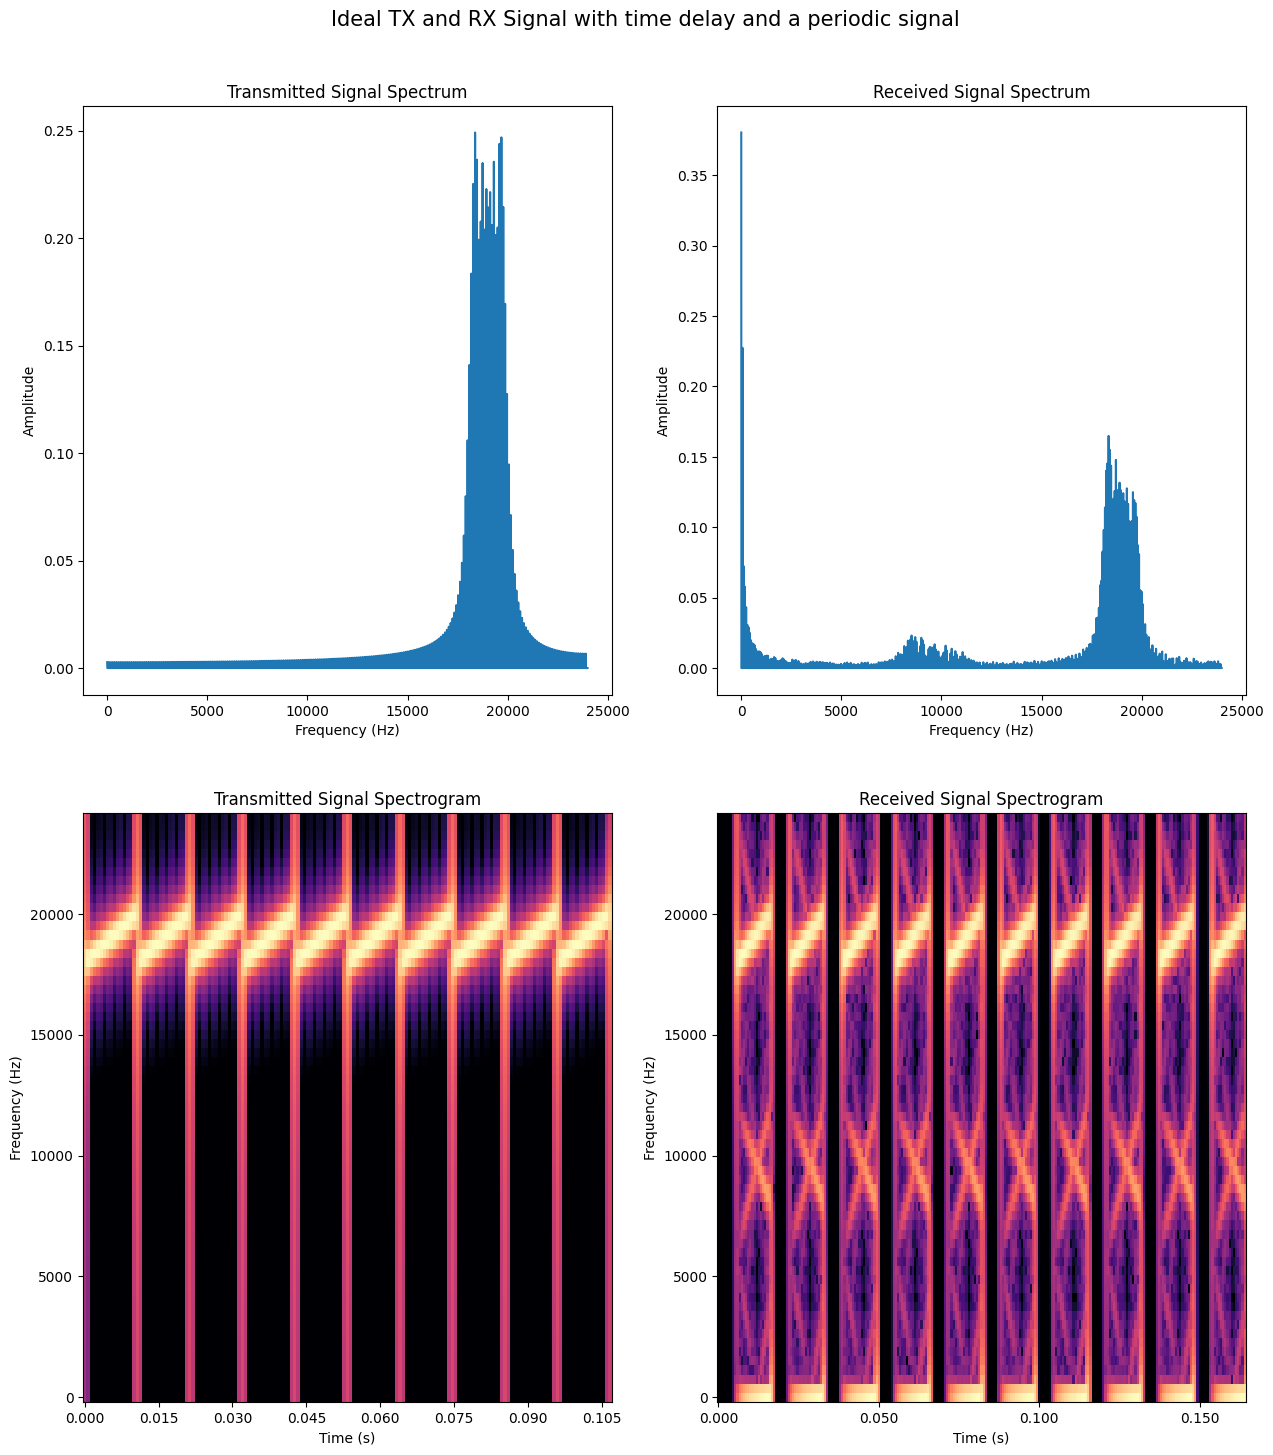

In [100]:
# Plot the spectrum and spectrogram of the transmitted and received signal

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(15, 16))
fig.suptitle("Ideal TX and RX Signal with time delay and a periodic signal", fontsize = 15)

ax1.plot(F_in,A_in)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Transmitted Signal Spectrum')

ax2.plot(F_out,A_out)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Received Signal Spectrum')

plot_spectogram(signal,sample_rate, n_fft=128, title='Transmitted Signal Spectrogram', ax=ax3)
ax3.set_title('Transmitted Signal Spectrogram')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')

plot_spectogram(chirp_rec,sample_rate, n_fft=128, title='Received Signal Spectrogram', ax=ax4)
ax4.set_title('Received Signal Spectrogram')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Frequency (Hz)')

plt.subplots_adjust(top=0.92)

Multiplied Signal

In [101]:
# Element-wise multiplication of the transmitted signal and received signal

if signal.shape[0] < chirp_rec.shape[0]:
    chirp_rec = chirp_rec[:signal.shape[0]]
else:
    signal = signal[:chirp_rec.shape[0]]

#mixed = signal[280:] * chirp_rec[280:512] # overlapping part
mixed = signal[:] * chirp_rec[:] # overlapping part

# Compute FFT and plot the spectrum of mixed signal
F,A = compute_fft(mixed, sample_rate)

# Print top 10 fft freq and their amplitudes for mixed signal
sort_mixed = np.argsort(A)[::-1]
for i in range(10):
    print("Freq:", F[sort_mixed[i]], "Amplitude: ", A[sort_mixed[i]])


Freq: 337.5 Amplitude:  0.06339015368300521
Freq: 553.125 Amplitude:  0.060932639823200054
Freq: 543.75 Amplitude:  0.055660042731757876
Freq: 562.5 Amplitude:  0.05038328338164858
Freq: 10181.25 Amplitude:  0.04909141119519729
Freq: 178.125 Amplitude:  0.04738088742700949
Freq: 487.5 Amplitude:  0.04701982761969048
Freq: 10021.875 Amplitude:  0.04615260039157373
Freq: 18750.0 Amplitude:  0.04593780220868976
Freq: 150.0 Amplitude:  0.04493946769720086


IF Signal

In [102]:
# Apply a lowpass filter on the multiplied signal to obtain IF signal
cutoff = (186046.511 * delay_duration) # beat frequnecy fb
cutoff = round(cutoff, 4)

if_signal = butter_lowpass_filter(mixed, cutoff, sample_rate, 5)

print("Beat freq:" ,cutoff, "Hz")
signal_info(if_signal, sample_rate)

Beat freq: 1079.0698 Hz
Sampling Rate: 48000
Signal time duration:  0.10666666666666667
Number of samples:  5120


In [103]:
F_if,A_if = compute_fft(if_signal, sample_rate)
print(F_if[np.argmax(A_if)])

# Print top 10 fft freq and their amplitudes for mixed signal
sort_if = np.argsort(A_if)[::-1]
for i in range(10):
    print("Freq:", F_if[sort_if[i]], "Amplitude: ", A_if[sort_if[i]])

#for i in range(len(F_if)):
#    print(F_if[i])

337.5
Freq: 337.5 Amplitude:  0.06310859989945611
Freq: 553.125 Amplitude:  0.061193719042812164
Freq: 543.75 Amplitude:  0.05605374078602634
Freq: 562.5 Amplitude:  0.050018951287850964
Freq: 487.5 Amplitude:  0.04720494919893065
Freq: 178.125 Amplitude:  0.04718701085127373
Freq: 150.0 Amplitude:  0.044957892084841126
Freq: 187.5 Amplitude:  0.03951760988592784
Freq: 496.875 Amplitude:  0.03861167941263878
Freq: 309.375 Amplitude:  0.037902097741069604


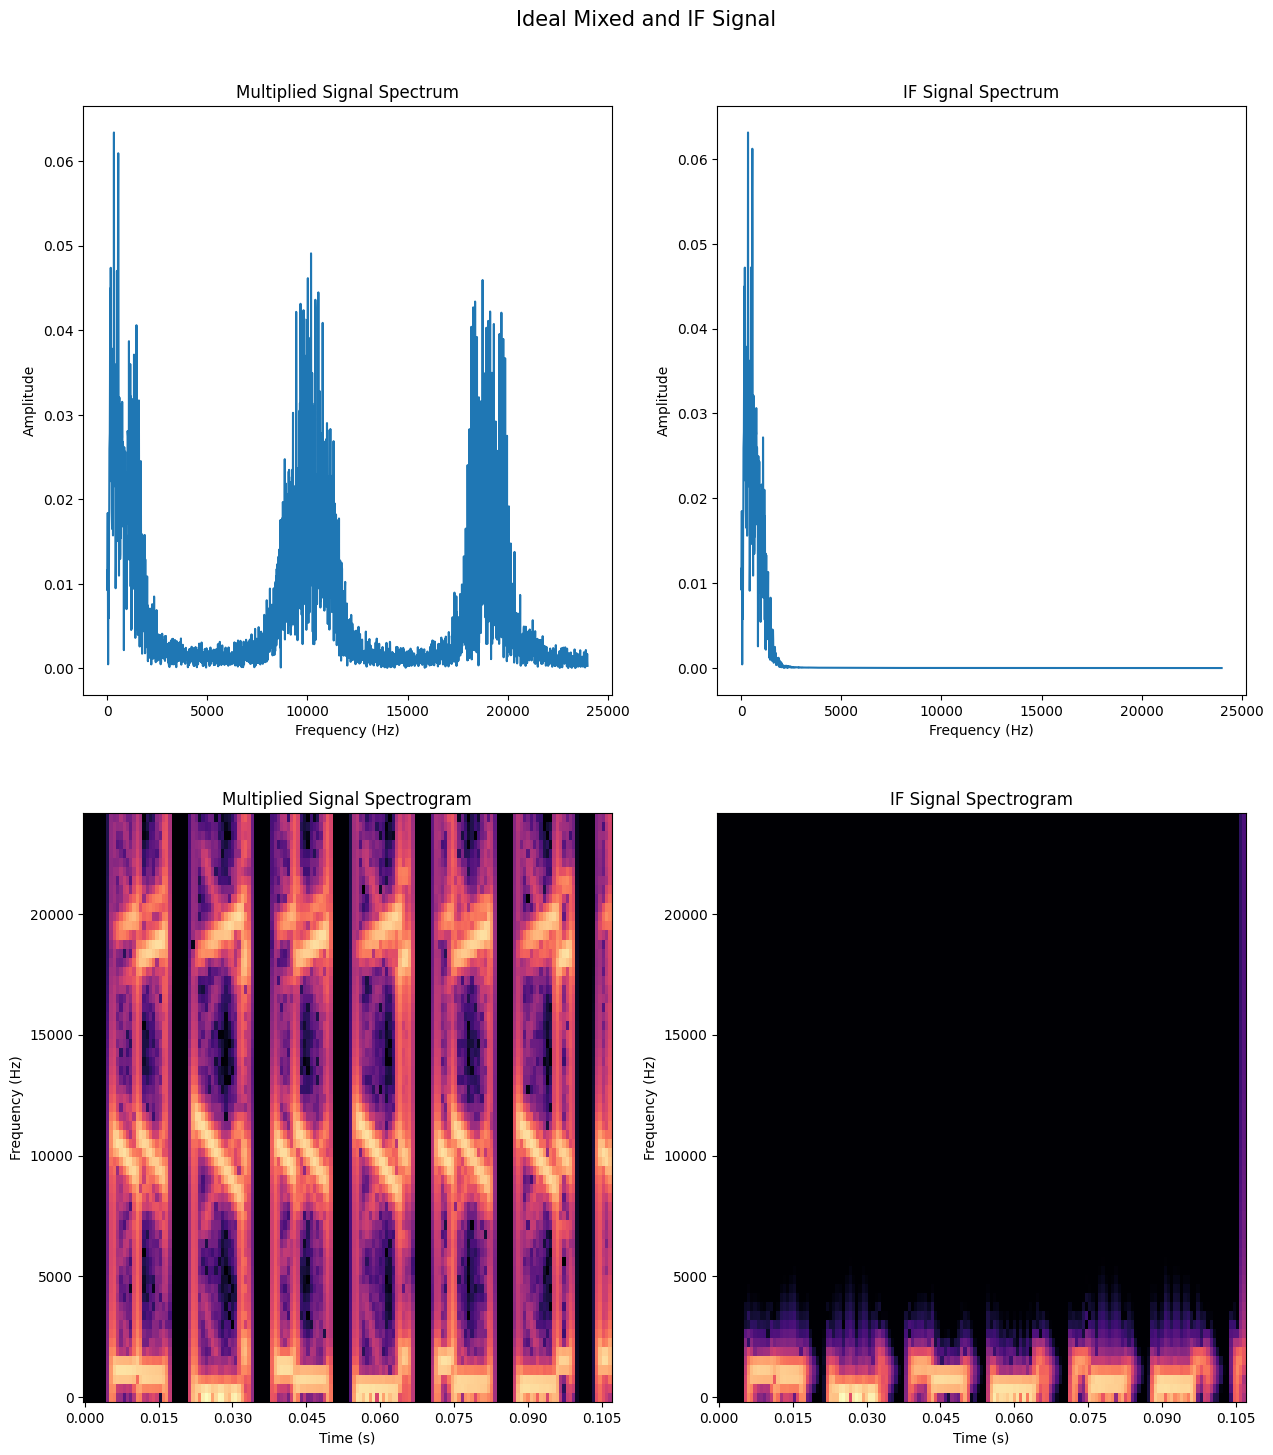

In [104]:
# Plot the spectrum and spectrogram of the transmitted and received signal

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(15, 16))
fig.suptitle("Ideal Mixed and IF Signal", fontsize = 15)

ax1.plot(F,A)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Multiplied Signal Spectrum')

ax2.plot(F_if,A_if)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('IF Signal Spectrum')

plot_spectogram(mixed,sample_rate, n_fft=128, title='Multiplied Signal Spectrogram', ax=ax3)
ax3.set_title('Multiplied Signal Spectrogram')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')

plot_spectogram(if_signal,sample_rate, n_fft=128, title='IF Signal Spectrogram', ax=ax4)
ax4.set_title('IF Signal Spectrogram')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Frequency (Hz)')

plt.subplots_adjust(top=0.92)

Breathing Signal Frequnecy Shift - 11.7Hz

In [105]:
breathing_cutoff = 20
breathing_signal = butter_lowpass_filter(mixed, breathing_cutoff, sample_rate, 5)

Maximum frequency in breathing signal:  18.75
Freq: 18.75 Amplitude:  0.010444318557650763
Freq: 9.375 Amplitude:  0.01023446436059103
Freq: 0.0 Amplitude:  0.010034267001589865
Freq: 28.125 Amplitude:  0.004172970754039112
Freq: 37.5 Amplitude:  0.0008875921952399045
Freq: 46.875 Amplitude:  0.00047420942580336394
Freq: 56.25 Amplitude:  0.0004075481022843214
Freq: 65.625 Amplitude:  0.00029091274986714385
Freq: 75.0 Amplitude:  0.0002786838154417964
Freq: 84.375 Amplitude:  0.00023575234750993057
0.0
9.375
18.75
28.125
37.5
46.875
56.25
65.625
75.0
84.375
93.75
103.125
112.5
121.875
131.25
140.625
150.0
159.375
168.75
178.125
187.5
196.875
206.25
215.625
225.0
234.375
243.75
253.125
262.5
271.875
281.25
290.625
300.0
309.375
318.75
328.125
337.5
346.875
356.25
365.625
375.0
384.375
393.75
403.125
412.5
421.875
431.25
440.625
450.0
459.375
468.75
478.125
487.5
496.875
506.25
515.625
525.0
534.375
543.75
553.125
562.5
571.875
581.25
590.625
600.0
609.375
618.75
628.125
637.5
646.875
65

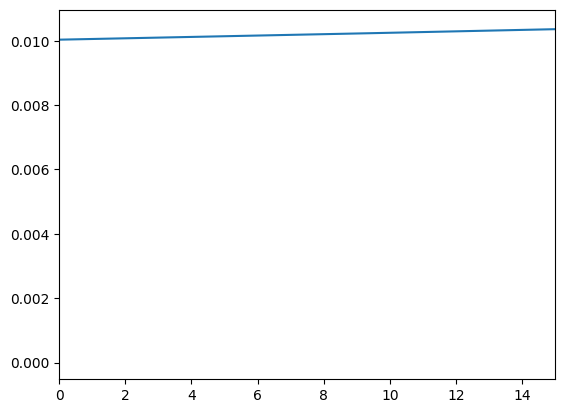

In [106]:
F_breathing, A_breathing = compute_fft(breathing_signal, sample_rate)

print("Maximum frequency in breathing signal: ", F_breathing[np.argmax(A_breathing)])

plt.plot(F_breathing, A_breathing)
plt.xlim(0,15)
sort_index = np.argsort(A_breathing)[::-1]
for i in range(10):
    print("Freq:", F_breathing[sort_index[i]], "Amplitude: ", A_breathing[sort_index[i]])


for i in range(len(F_breathing)):
     print(F_breathing[i])


In [107]:
c = 3e8
r = (c*0.01075*10*cutoff)/(2*2000)
range_res = c/(2*2000)
print(r)
print(range_res)

8700000.262499997
75000.0
